## Assessing Salmon Harvests in Alaska


In [318]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from colormap import Colormap

#### Clean up the timeseries excel sheet
The historical data separated information by species into different sheets. This code goes through each sheet, adds a column called "species" and then puts all that data into a single dataframe, called all_fish.

#### Adjust dollars for inflation
Adding in a CPI table to convert nominal dollars into 2017 dollars.  
Consult https://www.bls.gov/cpi/cpi1998d.htm to understand how to use the CPI adjustment:  
* CPI for current period (250) **less** CPI for previous period (230) **equals** index point change (20)
* Divide index point change by previous period CPI (230) == 0.0869 to find percent change

In sum: look for percent change in the index between years.

#### The end result is timeseries with fish harvest counts, with nominal and inflation-adjusted values, by species.

In [349]:
# Data source for "2016_12_27  Historical salmon exvessel & number of fish charts.xlsx" was a 
# personal email communication with Jennifer Shriver, ADFG on Tue, Apr 25, 2017 at 2:55 PM.
# jennifer.shriver@alaska.gov

# 1975 through current data is available online at 
# http://www.adfg.alaska.gov/index.cfm?adfg=commercialbyfisherysalmon.salmon_grossearnings_byspecies

fish_species = ['chinook', 'coho', 'sockeye', 'pink', 'chum']

collected_data = ['Year','Harvest (thousands of fish)','Value (nominal dollars)']

all_fish = pd.DataFrame(columns=collected_data)

for fish in fish_species:
    name = fish.upper()+" CHART"
    fish_df = pd.read_excel("data/2016_12_27  Historical salmon exvessel & number of fish charts.xlsx",
                            sheetname=name,
                            skiprows=32,
                            header=None,
                            names = collected_data,
                            na_values = 0
                           )
    fish_df['Species'] = fish
    all_fish = pd.concat([all_fish,fish_df], axis=0)
    
all_fish['Year'] = all_fish['Year'].astype(int)

# Adjust the nominal harvest dollars for inflation
# Source: US Bureau of Labor Statistics
# Site: https://data.bls.gov/pdq/SurveyOutputServlet

cpi = pd.read_table('data/CPI_Adjustment_1913_to_2017.csv', skiprows=8, sep=',')
# Make a new column for inflation-adjusted values
CPI2017 = cpi[cpi['Year']==2017]['Annual'].values[0]

cpi['2017 multiplier'] = (CPI2017 - cpi['Annual'])/cpi['Annual']
# 2017 multiplier is how much a 1913 dollar would buy in 2017 dollars

all_fish = pd.merge(all_fish, cpi[['2017 multiplier', 'Year']], on='Year')
#del all_fish['Annual']

all_fish['Value (2017 dollars)'] = all_fish['Value (nominal dollars)']*all_fish['2017 multiplier']
all_fish.head()

,Harvest (thousands of fish),Species,Value (nominal dollars),Year,2017 multiplier,Value (2017 dollars)
0,508.00,chinook,nan,1913,23.65,nan
1,796.00,coho,nan,1913,23.65,nan
2,"28,373.00",sockeye,nan,1913,23.65,nan
3,"26,773.00",pink,nan,1913,23.65,nan
4,"2,853.00",chum,nan,1913,23.65,nan


#### Information about the Pacific Decadal Oscillation

The PDO is an ocean phenomonon that periodically changes the dominant temperature regime in the North Pacific. The PDO index tracks where the PDO is within its cycle. This data is available from noaa on a monthly basis.  The code below first plots the monthly data and then takes the annual mean PDO index value, and plots the annual mean PDO.

In [325]:
pdo = pd.read_table('data/PDO.latest.txt',skiprows=33, delim_whitespace=True, skipfooter=16,
                    # change the column headers to integer months instead of text abbreviation months
                    names = ['YEAR','1','2','3','4','5','6','7','8','9','10','11','12']
                   )

# remove the ** on the years after 2002, convert this string column to integers
pdo['YEAR'] = pdo['YEAR'].str.replace("\*\*","").astype(int)

# convert this wide data to long data by changing the month columns into a variable
# called month and the value in the cell to the column "PDO_Index"
# and separate them based on the "year"

pdo = pdo.melt(var_name='MONTH', value_name='PDO_index', id_vars=['YEAR'])
pdo['MONTH'] = pdo['MONTH'].astype(int)
pdo.sort_values(by=['YEAR','MONTH'], ascending=True, inplace=True)
pdo.reset_index(inplace=True, drop=True)
pdo.head()

/Users/kasiana.mclenaghan/.virtualenvs/somaclass/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


,YEAR,MONTH,PDO_index
0,1900,1,0.04
1,1900,2,1.32
2,1900,3,0.49
3,1900,4,0.35
4,1900,5,0.77


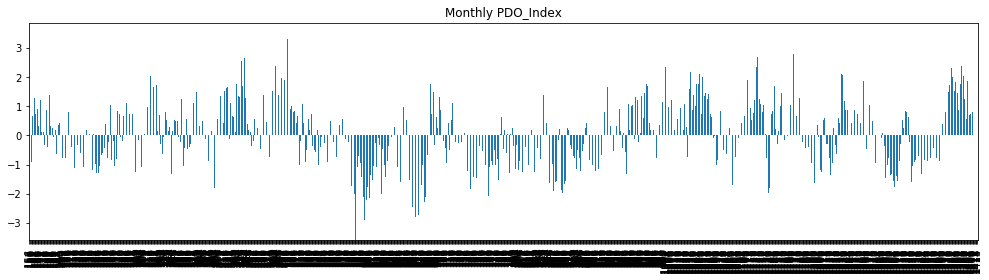

In [348]:
modern = pdo['YEAR'] > 1912

pdo[modern]['PDO_index'].plot(kind='bar', figsize=(17,4)).set_title("Monthly PDO_Index")

In [327]:
pdo['PDO_index'].describe()

count   1,410.00
mean        0.04
std         1.04
min        -3.60
25%        -0.66
50%         0.06
75%         0.75
max         3.51
Name: PDO_index, dtype: float64

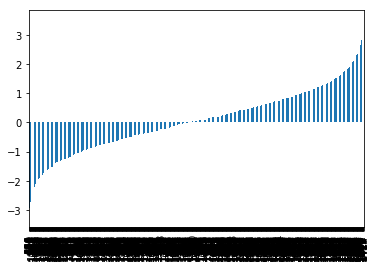

In [328]:
pdo_hist = pdo['PDO_index'].sort_values()
pdo_hist.plot(kind='bar')

#### Color codes
Next step is to a) average out the PDO index by year, and b) create a quantile gradient to map the PDO onto the harvest bar chart.

In [329]:
pdo.head()

,YEAR,MONTH,PDO_index
0,1900,1,0.04
1,1900,2,1.32
2,1900,3,0.49
3,1900,4,0.35
4,1900,5,0.77


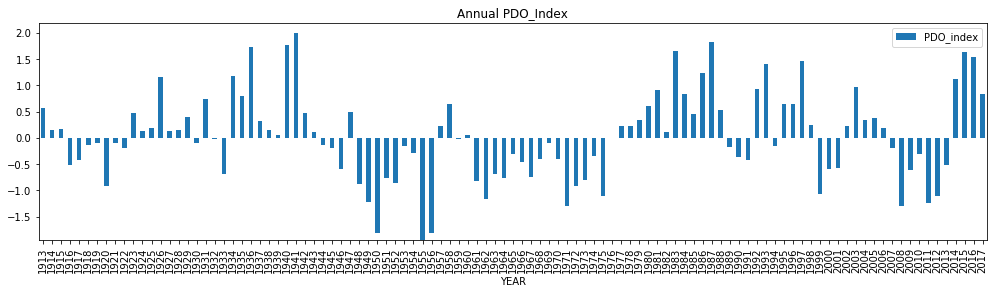

In [347]:
pdo_annual = pdo[['YEAR', 'PDO_index']].groupby('YEAR').mean()
pdo_annual.reset_index(inplace=True)
pdo_annual['YEAR'] = pdo_annual['YEAR'].astype(int)
#pdo_annual.head()
modern = pdo_annual['YEAR'] > 1912

pdo_annual[modern].plot(x='YEAR',kind='bar',figsize=(17,4)).set_title("Annual PDO_Index")

In [322]:
pdo_annual['PDO_index'].describe()

count   118.00
mean      0.05
std       0.80
min      -1.95
25%      -0.42
50%       0.06
75%       0.49
max       1.99
Name: PDO index, dtype: float64

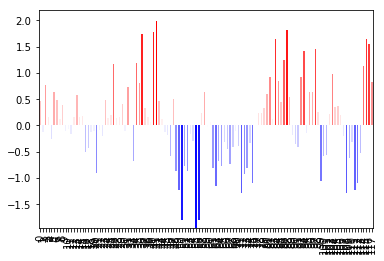

In [336]:
# We create a dataframe
pdo_colorscore = pdo_annual

# "We want our colors to slowly go from blue, then to white, then to red"
# You can see it work if you run 'cmap(0)' or 'cmap(0.25)' or whatever
c = Colormap()
cmap = c.cmap_linear('blue', 'white', 'red')

# default, 0 = red, 0.5 = white, 1 = green
# ...but that doesn't work with our data! So before we get the
# colors, we need to build something to scale our values.
# I picked -100 as the bottom, 100 the top.
# White will be in the middle.
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)

# Go through every single 'score' and
# NORMALIZE the value to between 0 and 1 using norm
# then COLORIZE using the color map
colors = pdo_colorscore.PDO_index.apply(lambda value: cmap(norm(value)))

# Then feed it into the plot as a list of colors
# It has to be a list for god knows what reason
pdo_colorscore.plot(y='PDO_index', kind='bar', color=[colors], legend=False)

#pdo_colorscore.head()

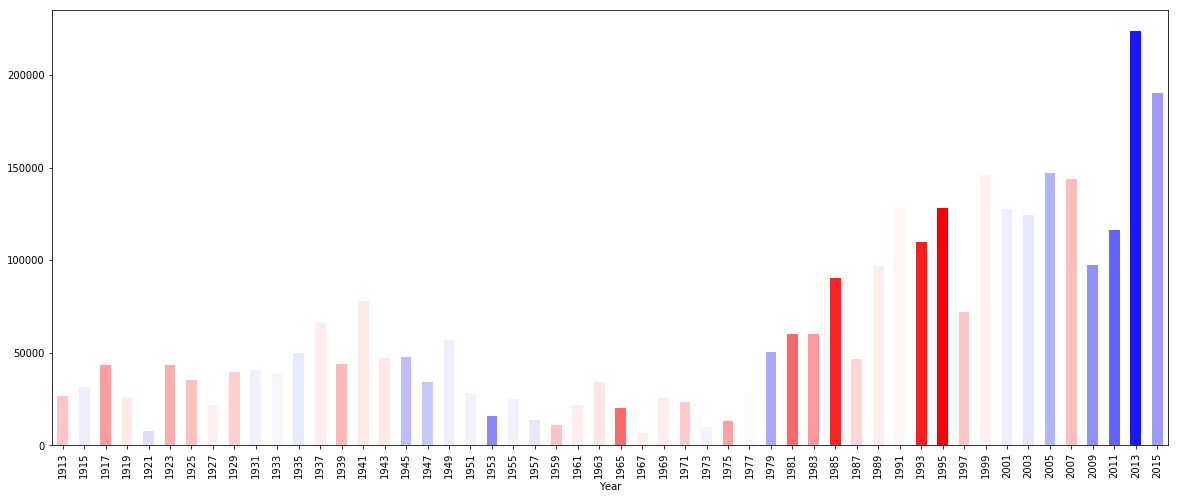

In [338]:
pinks = all_fish['Species']=='pink'
odd_years = (all_fish['Year'] % 2 > 0)
even_years = (all_fish['Year'] % 2 == 0)


all_fish[pinks & odd_years].plot(x='Year', y='Harvest (thousands of fish)', kind='bar', color=[colors], figsize=(20,8), legend=False)

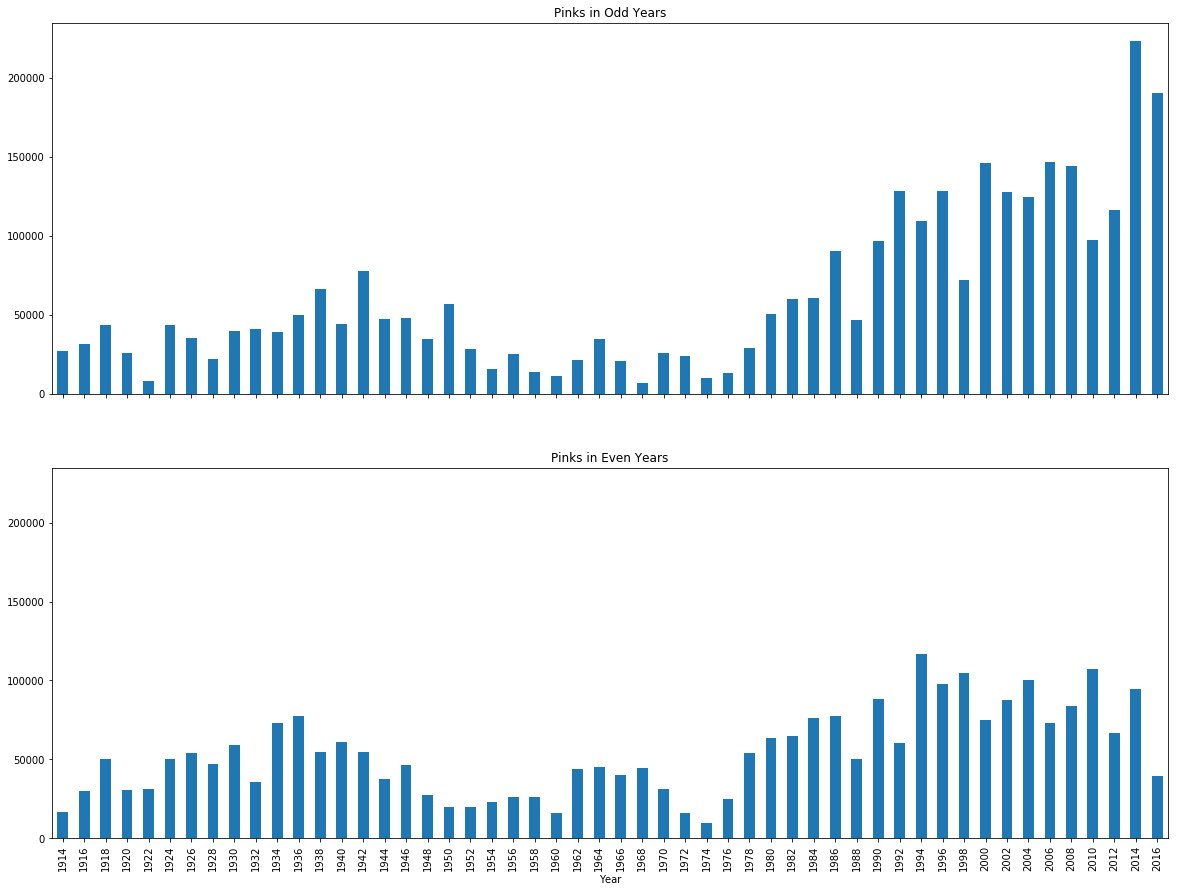

In [340]:
# Creating TWO subplots, ax1 and ax2.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(20,15))

all_fish[pinks & odd_years].plot(x='Year',y='Harvest (thousands of fish)', ax=ax1, kind='bar', legend=False)
ax1.set_title("Pinks in Odd Years")

all_fish[pinks & even_years].plot(x='Year',y='Harvest (thousands of fish)', ax=ax2, kind='bar', legend=False)
ax2.set_title("Pinks in Even Years")

# If you don't do tight_layout() you'll have weird overlaps
#plt.tight_layout()

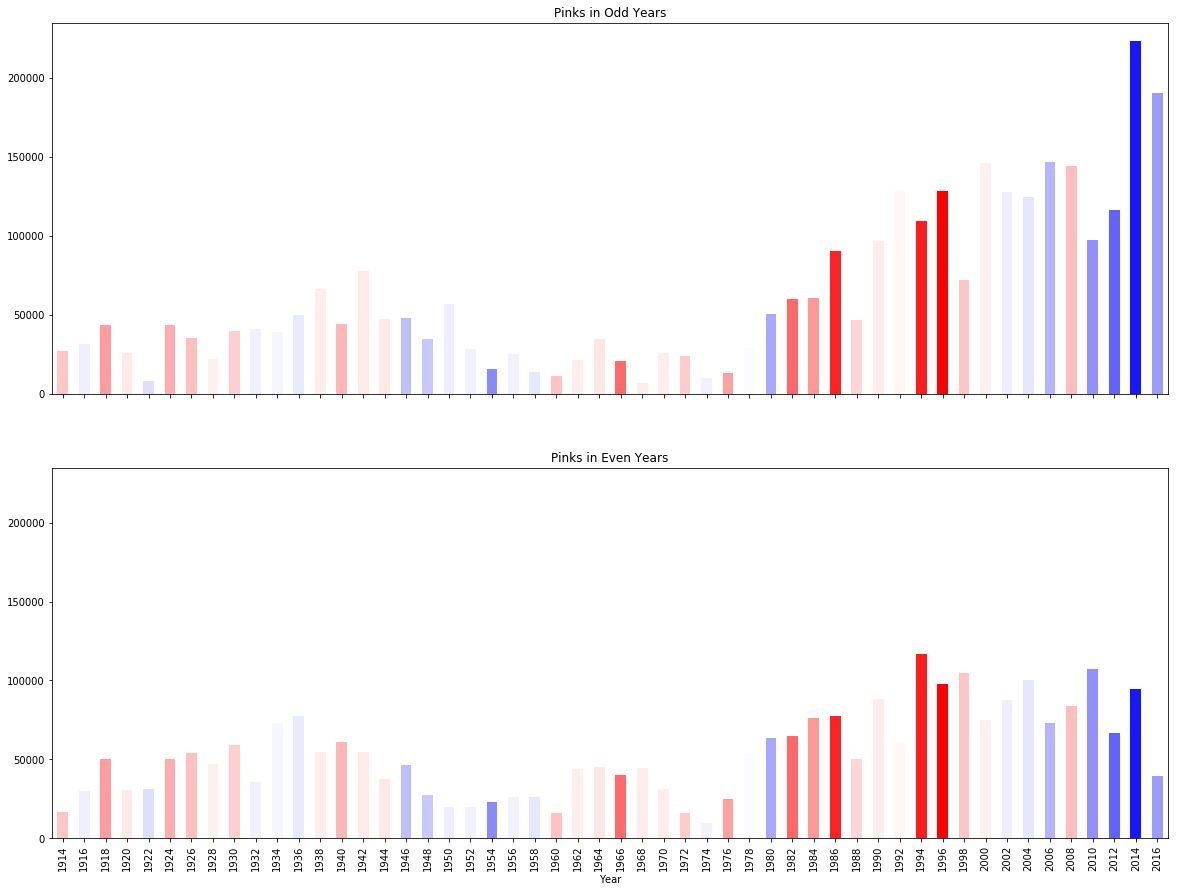

In [341]:
# Creating TWO subplots, ax1 and ax2.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(20,15))

all_fish[pinks & odd_years].plot(x='Year',y='Harvest (thousands of fish)', ax=ax1, kind='bar', color=[colors], legend=False)
ax1.set_title("Pinks in Odd Years")

all_fish[pinks & even_years].plot(x='Year',y='Harvest (thousands of fish)', ax=ax2, kind='bar', color=[colors], legend=False)
ax2.set_title("Pinks in Even Years")

# If you don't do tight_layout() you'll have weird overlaps
#plt.tight_layout()

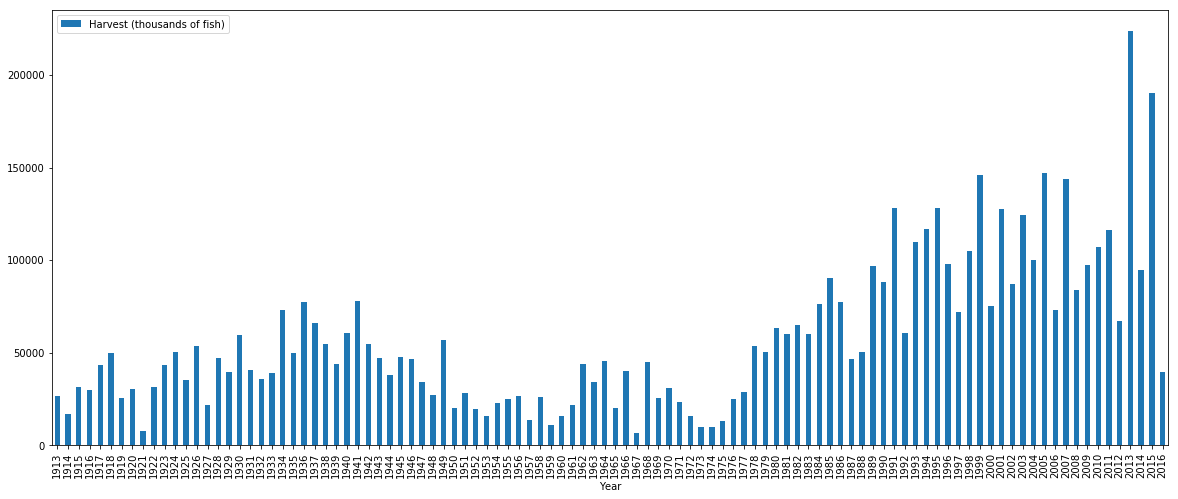

In [238]:
all_fish[pinks].plot(x='Year',y='Harvest (thousands of fish)', kind='bar', figsize=(20,8))